In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import trend_visuals

In [4]:
data = pd.read_csv('../data/skylab_instagram_datathon_dataset.csv', delimiter=';')

In [6]:
trends_brand, trends_all, trends_cumulative, dates = trend_visuals.brand_level_trends(data, 'H&M')

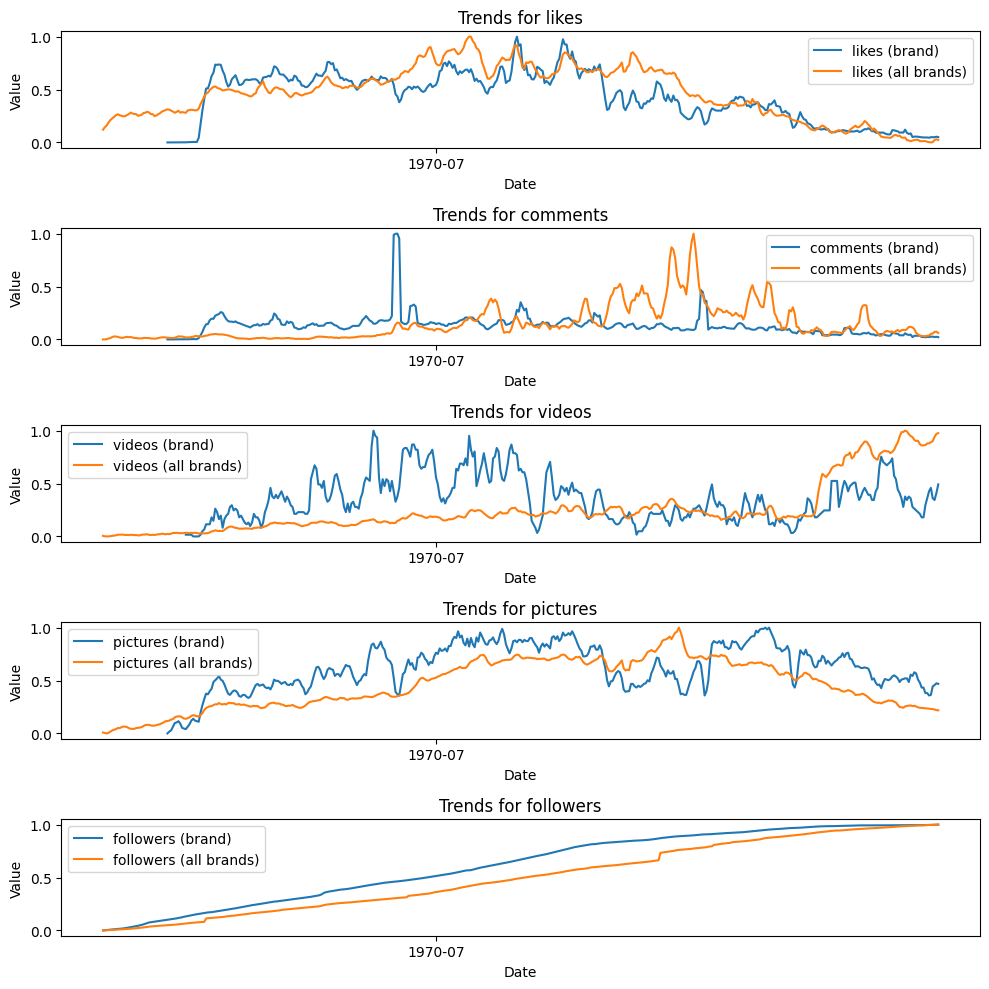

In [7]:
trend_visuals.plot_metrics_individual(trends_brand, trends_all, dates)

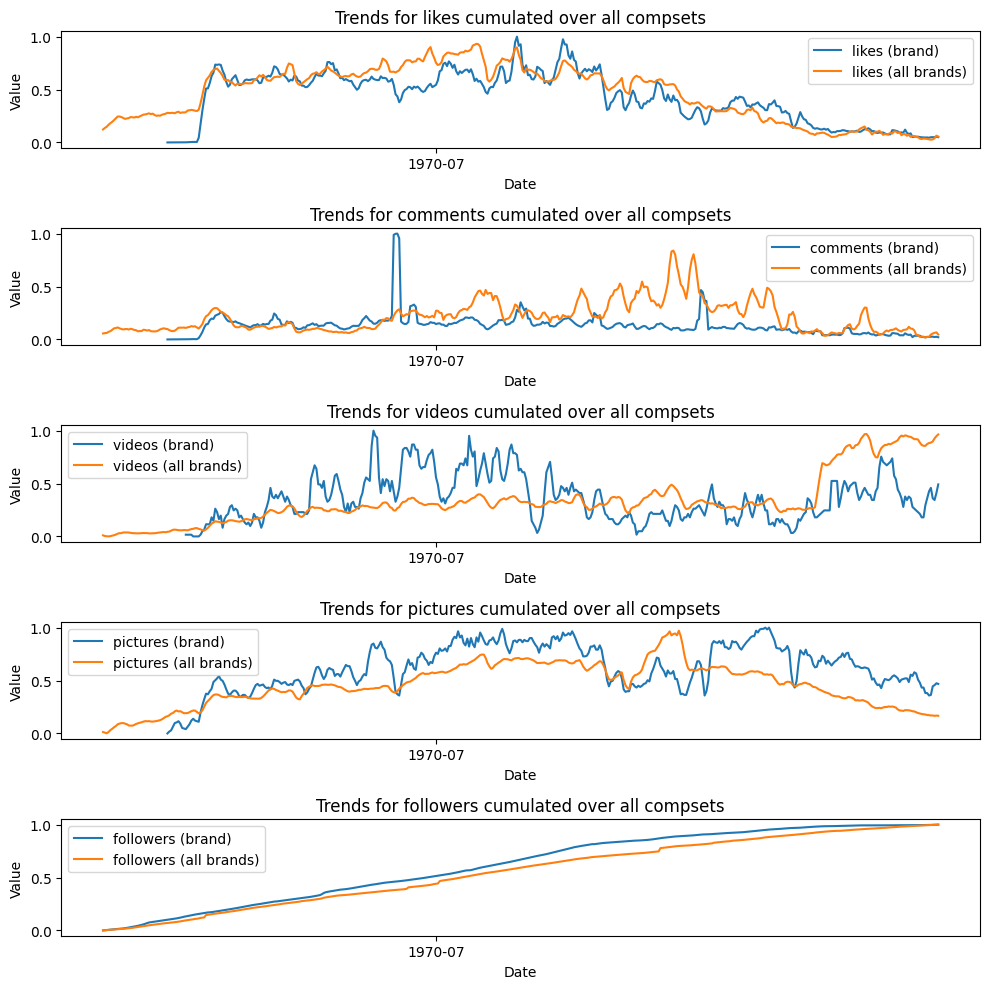

In [8]:
trend_visuals.plot_metrics_total(trends_brand, trends_cumulative, dates)

In [ ]:
def plot_metrics_window(trends_brand, trends_cumulative, dates, window_start=0, window_end=100):
    metrics = ['likes', 'comments', 'videos', 'pictures', 'followers']
    fig, axs = plt.subplots(5, 1, figsize=(10, 10))

    for i in range(5):
        trend_brand = (trends_brand[i][window_start:window_end] - trends_brand[i][window_start:window_end].min()) / (trends_brand[i][window_start:window_end].max() - trends_brand[i][window_start:window_end].min())
        trend_cumulative = (trends_cumulative[i][window_start:window_end] - trends_cumulative[i][window_start:window_end].min()) / (trends_cumulative[i][window_start:window_end].max() - trends_cumulative[i][window_start:window_end].min())

        axs[i].plot(dates[window_start:window_end], trend_brand, label=f'{metrics[i]} (brand)')
        axs[i].plot(dates[window_start:window_end], trend_cumulative, label=f'{metrics[i]} (all brands)')

        axs[i].set_title(f'Trends for {metrics[i]} cumulated over all compsets')
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Normalized Value')
        axs[i].legend()

        axs[i].xaxis.set_major_locator(mdates.MonthLocator(interval=12))
        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.tight_layout()
    plt.show()

plot_metrics_window(trends_brand, trends_cumulative, dates, window_start=0, window_end=100)

In [ ]:
def moving_average(a, window_size=3):
    return np.convolve(a, np.ones(window_size), 'valid') / window_size

def remove_outliers(signal, window_size=60, n_std_dev=3):
    # Calculer la moyenne mobile et l'écart-type mobile
    moving_avg = np.convolve(signal, np.ones(window_size), 'same') / window_size
    moving_std = np.array([np.std(signal[max(0, i-window_size+1):i+1]) for i in range(len(signal))])

    # Identifier les valeurs aberrantes
    outliers = np.abs(signal - moving_avg) > n_std_dev * moving_std

    # Remplacer les valeurs aberrantes par la moyenne mobile
    signal_clean = np.where(outliers, moving_avg, signal)

    return signal_clean

def normalize(signal):
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))


like_cum = moving_average(trends_cumulative[0], window_size=10)
like_brand = remove_outliers(trends_brand[0])

like_cum = normalize(like_cum)
like_brand = normalize(like_brand)


fig, axs = plt.subplots(2, 1, figsize=(10, 4))

axs[0].plot(like_cum, label='Total')
axs[0].set_title('like_cum')
axs[0].legend()

axs[1].plot(like_cum, label='Baseline', color='orange')
axs[1].plot(like_brand, label='Brand')
axs[1].set_title('Baseline')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
def detect_outliers(series):
    Q1 = np.percentile(series, 25)
    Q3 = np.percentile(series, 75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return ((series < lower_bound) | (series > upper_bound))

def extract_features(trends_brand, trends_cumulative, dates, window_size=100, window_overlap=0.5):
    outlier_dates_brand = []
    outlier_dates_cumulative = []

    for i in range(0, len(dates)-window_size, int(window_size*window_overlap)):
        outlier_mask_brand = detect_outliers(trends_brand[0][i:i+window_size])
        outlier_mask_cumulative = detect_outliers(trends_cumulative[0][i:i+window_size])

        outlier_dates_brand.extend(dates[i:i+window_size][outlier_mask_brand])
        outlier_dates_cumulative.extend(dates[i:i+window_size][outlier_mask_cumulative])

        outlier_dates_brand = [date for date in outlier_dates_brand if date not in outlier_dates_cumulative]

    return np.array(outlier_dates_brand)


print(extract_features(trends_brand, trends_cumulative, dates, window_size=50, window_overlap=0.5))

import matplotlib.pyplot as plt

def plot_signals_with_outliers(trends_brand, trends_cumulative, dates, window_size=10, window_overlap=0.5):
    outlier_dates = extract_features(trends_brand, trends_cumulative, dates, window_size, window_overlap)

    plt.figure(figsize=(10, 3))
    plt.plot(dates, trends_brand[0], label='Brand')
    plt.plot(dates, trends_cumulative[0], label='Cumulative')
    plt.scatter(outlier_dates, [trends_brand[0][dates == date][0] for date in outlier_dates], color='red', label='Outliers')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.savefig('Outlier.png')
    plt.show()

plot_signals_with_outliers(trends_brand, trends_cumulative, dates)